# Move video file to folder

In [30]:
import os
import glob
import shutil
import pathlib

for url in glob.glob(os.getcwd() + "/data/*.mp4"):
    fileName = os.path.basename(url).rsplit( ".", 1 )[ 0 ].replace('VID_', '')
    if(os.path.exists(url)):
        shutil.move(url, str(pathlib.Path().resolve()) + "\\data\\" + fileName)

# Compute orientation from Gyro

In [2]:
import csv
import math
import numpy as np
import cv2
from scipy import integrate
import matplotlib.pyplot as plt

def computeOrientation(fileName, displayGraph=False):
    gyroX, gyroY, gyroZ, time = [], [], [], []
    dt = 1/400 #400Hz

    data_file = open(os.getcwd() + "/data/" + fileName + '/VID_' + fileName + 'gyro.csv',  'r')
    orientation_file = open(os.getcwd() + "/data/" + fileName + '/VID_' + fileName + 'orientation.csv',  'w+', newline="")

    data_reader = csv.reader(data_file)
    writer = csv.writer(orientation_file)

    t_init, t_final, counter = 0, 0, 0
    
    for row in data_reader:
        gyroX.append(float(row[0]))
        gyroY.append(float(row[1]))
        gyroZ.append(float(row[2]))
        time.append(int(row[3]))
        
        t_final = int(row[3])
        counter += 1
        if t_init == 0:
            t_init = int(row[3])


    x = np.linspace(0, abs(t_final - t_init)/1e9, num=counter)
    X_int = integrate.cumtrapz(gyroX, dx=dt, initial=0)
    Y_int = integrate.cumtrapz(gyroY, dx=dt, initial=0)
    Z_int = integrate.cumtrapz(gyroZ, dx=dt, initial=0)

    if displayGraph:
        plt.plot(x, X_int*(180/math.pi), color="g", label="x")
        plt.plot(x, Y_int*(180/math.pi), color="r", label="y")
        plt.plot(x, Z_int*(180/math.pi), color="b", label="z")
        plt.xlabel('time (s)')
        plt.ylabel('orientation (degree)') 
        plt.legend()
        plt.title("Rotation of the file: " + fileName)
        plt.show()


    for i in range(len(time)):
        writer.writerow([X_int[i]*(180/math.pi), Y_int[i]*(180/math.pi), Z_int[i]*(180/math.pi), time[i], gyroX[i], gyroY[i], gyroZ[i]])

    data_file.close()
    orientation_file.close()

## For specific file

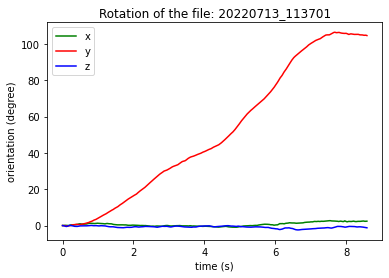

In [78]:
computeOrientation(fileName="20220713_113701", displayGraph=True)

## For entire dataset

In [25]:
import os 
import time
from IPython.display import clear_output

displayGraph = False

dataset_list = os.listdir(os.getcwd() + "/data")

for file in dataset_list:
    if file == ".DS_Store":
        continue
    computeOrientation(fileName=file, displayGraph=displayGraph)
    if displayGraph:
        time.sleep(1)
        os.system('clear')
        clear_output(wait=True)

# Sync orientation to video frame

In [315]:
import csv
import math
import numpy as np
import cv2

def processData(fileName, sensorType):

    time_file, data_file, data_processed = "", "", ""

    try:
        time_file = open(os.getcwd() + "/data/" +  fileName+ '/VID_' + fileName  + '_imu_timestamps.csv', 'r')
        data_file = open(os.getcwd() + "/data/" +  fileName+ '/VID_' + fileName  +  sensorType + '.csv', 'r')
        data_processed = open(os.getcwd() + "/data/" +  fileName+ '/VID_' + fileName  + "_sync_" + sensorType + '.csv',  'w+', newline="")
    except:
        print("Some files in " + fileName + " are missing")
        return
        
    time_reader = csv.reader(time_file)
    data_reader = csv.reader(data_file)

    writer = csv.writer(data_processed)
    writer.writerow(["Rot_X (deg)", "Rot_Y (deg)", "Rot_Z (deg)", "Gyro_Time (ns)", "Gyro_X", "Gyro_Y", "Gyro_Z"])

    """Loop through the time data file and the gyro file; Then add the ones in gyro that have closest timestamp to the timestamp file"""
    #Time list
    time_list = list(time_reader)
    frame_counter = 0

    """GYRO/ACC/MAG"""
    data_processed = list() #This will be the list we will export as a CSV
    data_set = set() #Only add matched timestamp here

    """First entry"""
    first_orientation = []

    for row in data_reader:
        if frame_counter == len(time_list):
            break

        target_time = int(time_list[frame_counter][0]) #This will get the target timestamp
        if len(data_processed) == 0:
            data_processed.append(row)
            continue
        
        #   If the current time from gyro_csv file has a smaller time difference than that in the
        #   data_processed list. Then we replace
        if (abs(int(row[3]) - target_time) < abs(int(data_processed[-1][3]) - target_time)):
            #Check set to see if previous time is already matched; We don't want it to be matched already
            if int(data_processed[-1][3]) not in data_set:
                #Replace with timestamp that has smaller time diff
                data_processed[-1] = row 
        else:
            #Add last element in the processed list to the data_set to confirm it's been matched
            frame_counter += 1
            data_set.add(int(data_processed[-1][3]))
            # orientation_row = [float(data_processed[-1][0]),float(data_processed[-1][1]),float(data_processed[-1][2])]
            orientation_row = np.array(data_processed[-1]).astype(float)
            if first_orientation == []:
                first_orientation = np.array(orientation_row)
            orientation_row[0] -= first_orientation[0]
            orientation_row[1] -= first_orientation[1]
            orientation_row[2] -= first_orientation[2]

            #Add this element to the CSV file as well
            writer.writerow(orientation_row)
            #Then add current row to data_processed
            data_processed.append(row)

    assert(len(data_processed)-1 == len(time_list))

    time_file.close()
    data_file.close()


## For specific file

In [38]:
processData(fileName="20220713_090357", sensorType="orientation")

c:\Users\PeterNg\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:52: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\Users\PeterNg\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:52: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


## For entire dataset

In [39]:
import os 
import time
from IPython.display import clear_output


dataset_list = os.listdir(os.getcwd() + "/data")

for file in dataset_list:
    if file == ".DS_Store":
        continue
    processData(fileName=file, sensorType="orientation")

c:\Users\PeterNg\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:52: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


# Check orientation-to-frame accuracy

In [13]:
import numpy as np
fileName = "20220713_090421"

time_file = open(os.getcwd() + "/data/" +  fileName+ '/VID_' + fileName  + '_imu_timestamps.csv', 'r')
sync_file = open(os.getcwd() + "/data/" +  fileName+ '/VID_' + fileName  + "_sync_orientation.csv",  'r')

time_reader = csv.reader(time_file)
sync_reader = csv.reader(sync_file)

time_list = list(time_reader)
sync_list = list(sync_reader)[1:]

maxVal = -np.infty
minVal = np.infty

for i in range(len(time_list)):
    diff = float(time_list[i][0]) - float(sync_list[i][3])
    maxVal = max(diff, maxVal)
    minVal = min(diff, minVal)

print("Max offset error: " + str(maxVal/1e6) + "ms")
print("Min offset error: " + str(minVal/1e6) + "ms")

Max offset error: 1.210829ms
Min offset error: -1.225291ms


# Compute Quaternion From Gyroscope

In [12]:
import csv
import math
import numpy as np
import cv2
from scipy import integrate
import matplotlib.pyplot as plt
import mathutils

def quaternionProduct(q1, q2):
    w0, x0, y0, z0 = q1
    w1, x1, y1, z1 = q2
    return np.array([-x1 * x0 - y1 * y0 - z1 * z0 + w1 * w0,
                     x1 * w0 + y1 * z0 - z1 * y0 + w1 * x0,
                     -x1 * z0 + y1 * w0 + z1 * x0 + w1 * y0,
                     x1 * y0 - y1 * x0 + z1 * w0 + w1 * z0], dtype=np.float64)

def quaternionNormalize(pose_initial, q_grad, dt=1/400):
    quat = mathutils.Quaternion(np.asarray(pose_initial, dtype=np.float64) + dt * q_grad)
    return quat.normalized()


def euler_from_quaternion(x, y, z, w):
        """
        Convert a quaternion into euler angles (roll, pitch, yaw)
        roll is rotation around x in radians (counterclockwise)
        pitch is rotation around y in radians (counterclockwise)
        yaw is rotation around z in radians (counterclockwise)
        source: https://stackoverflow.com/questions/56207448/efficient-quaternions-to-euler-transformation
        """
        if w == 1:
            return 0,0,0
        roll_x = np.arctan2(y*z + x*w, 0.5 - z*z - w*w)
        pitch_y = np.arcsin(2.0 * (y*w - x*z))
        yaw_z = np.arctan2(2*(w*z+x*y), 1-2*(y*y+z*z))
          
        return roll_x, pitch_y, yaw_z # in radians

def computeQuaternion(fileName, displayGraph=False):
    quat_gyro = [0] * 4
    pose_initial = [0] * 4
    t_init, t_final, counter = 0, 0, 0
    dt = 1/400

    data_file = open(os.getcwd() + "/data/" + fileName + '/VID_' + fileName + 'gyro.csv',  'r')
    quat_file = open(os.getcwd() + "/data/" + fileName + '/VID_' + fileName + 'quaternion.csv',  'w+', newline="")
    quat_euler_file = open(os.getcwd() + "/data/" + fileName + '/VID_' + fileName + 'quaternion_euler.csv',  'w+', newline="")

    data_reader = csv.reader(data_file)
    writer = csv.writer(quat_file)
    euler_writer = csv.writer(quat_euler_file)

    q = []
    roll_list, pitch_list, yaw_list = list(), list(), list()

    #CSV Headers: qx, qy, qz, qw, time, gx, gy, gz
    for row in data_reader:
        if counter == 0:
            writer.writerow([0,0,0,0,int(row[3]), float(row[0]), float(row[1]), float(row[2])])
            q = [1,0,0,0]
        else:
            quat_gyro = list(np.array([0.0, float(row[0]), float(row[1]), float(row[2])]).astype(np.float64))
            q_grad = 0.5 * quaternionProduct(pose_initial, quat_gyro)
            new_pose = quaternionNormalize(pose_initial,q_grad,dt=dt)
            # delta_quat = [1, 0.5*dt*float(row[0]), 0.5*dt*float(row[1]), 0.5*dt*float(row[2])]
            # new_pose = quaternionProduct(pose_initial, delta_quat)
            writer.writerow([new_pose[0], new_pose[1], new_pose[2], new_pose[3], int(row[3]), float(row[0]), float(row[1]), float(row[2])])
            pose_initial, q = new_pose, new_pose
        counter += 1

        if displayGraph:
            """Quaternrion to Euler"""
            roll,pitch,yaw = euler_from_quaternion(x=q[1],y=q[2],z=q[3],w=q[0])
            roll_list.append(roll)
            pitch_list.append(pitch)
            yaw_list.append(yaw)

            euler_writer.writerow([roll*(-180/math.pi), pitch*(180/math.pi), yaw*(180/math.pi), int(row[3])])

            """Time"""
            t_final = int(row[3])
            if t_init == 0:
                t_init = int(row[3])


    if displayGraph:
        x = np.linspace(0, abs(t_final - t_init)/1e9, num=counter)
        plt.plot(x, np.asarray(roll_list)*(-180/math.pi), color="g", label="x")
        plt.plot(x, np.asarray(pitch_list)*(180/math.pi), color="r", label="y")
        plt.plot(x, np.asarray(yaw_list)*(180/math.pi), color="b", label="z")
        plt.xlabel('time (s)')
        plt.ylabel('orientation (degree)') 
        plt.legend()
        plt.title("Rotation of the file: " + fileName)
        plt.show()

    data_file.close()
    quat_file.close()   
    quat_euler_file.close()

# For a specific file

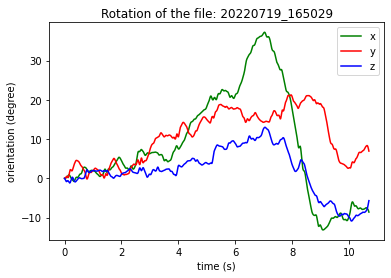

In [13]:
fileName = "20220719_165029"
computeQuaternion(fileName=fileName, displayGraph=True)

"""
Exceptions:
20220713_113701
20220713_114353
20220713_134934
20220713_134943
""";

# Sync Quaternion To Video Frame

In [10]:
import csv
import math
import numpy as np
import cv2
from decimal import Decimal

def quaternionProduct(q1, q2):
    w0, x0, y0, z0 = q1
    w1, x1, y1, z1 = q2
    return np.array([-x1 * x0 - y1 * y0 - z1 * z0 + w1 * w0,
                     x1 * w0 + y1 * z0 - z1 * y0 + w1 * x0,
                     -x1 * z0 + y1 * w0 + z1 * x0 + w1 * y0,
                     x1 * y0 - y1 * x0 + z1 * w0 + w1 * z0], dtype=np.float64)

def processQuaternion(fileName, sensorType="quaternion"):

    time_file, data_file, data_processed = "", "", ""

    try:
        time_file = open(os.getcwd() + "/data/" +  fileName+ '/VID_' + fileName  + '_imu_timestamps.csv', 'r')
        data_file = open(os.getcwd() + "/data/" +  fileName+ '/VID_' + fileName  +  sensorType + '.csv', 'r')
        data_processed = open(os.getcwd() + "/data/" +  fileName+ '/VID_' + fileName  + "_sync_" + sensorType + '.csv',  'w+', newline="")
    except:
        print("Some files in " + fileName + " are missing")
        return
        
    time_reader = csv.reader(time_file)
    data_reader = csv.reader(data_file)

    writer = csv.writer(data_processed)
    writer.writerow(["qw", "qx", "qy", "qz", "Gyro_Time (ns)"])

    """Loop through the time data file and the gyro file; Then add the ones in gyro that have closest timestamp to the timestamp file"""
    #Time list
    time_list = list(time_reader)
    frame_counter = 0

    """GYRO/ACC/MAG"""
    data_processed = list() #This will be the list we will export as a CSV
    data_set = set() #Only add matched timestamp here

    """First entry"""
    first_q = []

    for row in data_reader:
        if frame_counter == len(time_list):
            break

        target_time = int(time_list[frame_counter][0]) #This will get the target timestamp
        if len(data_processed) == 0:
            data_processed.append(row)
            continue
        
        #   If the current time from gyro_csv file has a smaller time difference than that in the
        #   data_processed list. Then we replace
        if (abs(int(row[4]) - target_time) < abs(int(data_processed[-1][4]) - target_time)):
            #Check set to see if previous time is already matched; We don't want it to be matched already
            if int(data_processed[-1][4]) not in data_set:
                #Replace with timestamp that has smaller time diff
                data_processed[-1] = row 
        else:
            #Add last element in the processed list to the data_set to confirm it's been matched
            frame_counter += 1
            data_set.add(int(data_processed[-1][4]))
            q = np.array(data_processed[-1]).astype(np.float64)
            if first_q == []:
                first_q = np.array(q[:4])
            # else:
            q_conj = np.array([first_q[0], -1*first_q[1], -1*first_q[2], -1*first_q[3]])
            q_inv = q_conj / pow(np.linalg.norm(q[:4]),2)
            q_relative = quaternionProduct(q[:4], q_inv)
                
            #Add this element to the CSV file as well
            writer.writerow([q_relative[0],q_relative[1],q_relative[2],q_relative[3],q[4]])
            #Then add current row to data_processed
            data_processed.append(row)

    assert(len(data_processed)-1 == len(time_list))

    time_file.close()
    data_file.close()


## For a Specific File

In [14]:
processQuaternion(fileName="20220719_165029", sensorType="quaternion")

c:\Users\PeterNg\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


# Visualize

In [1]:
import visualize
visualize.main(fileName="20220713_114353")

pygame 2.1.2 (SDL 2.0.18, Python 3.7.11)
Hello from the pygame community. https://www.pygame.org/contribute.html
fps: 28


NameError: name 'exit' is not defined